# Important - Instructions
**Make a copy of this notebook and do your work there. Save your notebook frequently and finally upload it on coderbyte within the timelimit.**

This notebook is divided into three sections, each dedicated to solving a specific task involving an autoencoder for the MNIST dataset. The tasks include fixing training issues, optimizing performance, and generating images.

At the end of each secion, briefly summarise what ideas/methods/changes (even those that you think didn't work) you've done for the section very briefly. This shouldn't take you more than ~5 minutes of your whole time.

# Overview of the tasks:
- **Fix Errors in Autoencoder Training/Inference:** Resolve any bugs in the training or inference process of the autoencoder.
- **Enhance Validation Loss:** Improve the autoencoder's performance by minimizing the validation loss.
- **Generate Images with the Optimized Model:** Use the best-trained model to generate images.

# Guidelines:
- **Imports:** Use only the imports already provided in the notebook. Any new import statements will be removed during evaluation.
- **Protected Code:** Certain cells are marked with # DO NOT MODIFY. Leave the code in these cells unchanged, but you may run the code.
- **Efficiency:** Ensure your solutions are written with efficiency in mind wherever applicable.

# Setup
You just have to run the code in this section

In [1]:
! pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
! pip install gdown

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
# DO NOT MODIFY
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import time
from numpy.typing import NDArray
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [3]:
# DO NOT MODIFY
import gdown

os.makedirs("data", exist_ok=True)

mnist_train_file_id = "1JMd32keTqqUAofWRPBnIg9PpusJD8mYt"
mnist_train_output = "data/mnist_dataset_train.pt"  # Desired filename for the downloaded file

mnist_test_file_id = "1OG8mBivCdXBwH8uCMvjWnVhHFtRagmSU"
mnist_test_output = "data/mnist_dataset_test.pt"  # Desired filename for the downloaded file

# Download the file
gdown.download(f"https://drive.google.com/uc?id={mnist_train_file_id}", mnist_train_output, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={mnist_test_file_id}", mnist_test_output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1JMd32keTqqUAofWRPBnIg9PpusJD8mYt
From (redirected): https://drive.google.com/uc?id=1JMd32keTqqUAofWRPBnIg9PpusJD8mYt&confirm=t&uuid=222aaba1-60f9-4478-ae2e-7f4eb561d590
To: /home/priyadarshin/Downloads/data/mnist_dataset_train.pt
100%|██████████████████████████████████████| 47.5M/47.5M [00:04<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8mBivCdXBwH8uCMvjWnVhHFtRagmSU
To: /home/priyadarshin/Downloads/data/mnist_dataset_test.pt
100%|██████████████████████████████████████| 7.92M/7.92M [00:00<00:00, 9.41MB/s]


'data/mnist_dataset_test.pt'

In [4]:
# DO NOT MODIFY
import gdown
file_id = "1v_-Gq58ee7w2WM977O4qXCiLhhGRwHVb"
output = "advanced_autoencoder_model.pth"  # Desired filename for the downloaded file

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

def load_pretrained_model():
  model = torch.load("advanced_autoencoder_model.pth")
  model.eval()
  return model

Downloading...
From: https://drive.google.com/uc?id=1v_-Gq58ee7w2WM977O4qXCiLhhGRwHVb
To: /home/priyadarshin/Downloads/advanced_autoencoder_model.pth
100%|████████████████████████████████████████| 455k/455k [00:00<00:00, 1.78MB/s]


# Section 1 - Fix autoencoder training
 This section doesn't require you to write a lot of code,  rather requires your attention to the details of standard ML training and inference.

**Expected time on this section: 20 minutes**<br>
**Maximum time on this section: 30 minutes**

In this section, you are given an AutoEncoder implementation along with code to train this model on reconstruction of MNIST images.

If you run the code as is, you will observe the visualisation doesn't work as expected. Your task is to figure out the bugs and fix them.

You know you have resolved the bugs if loss decreases considerably within 2 epochs and you are able to visualise non-trivial images reconstructed by the autoencoder (code for visualisation is provided at the end of this section).

In [5]:
# DO NOT MODIFY
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
def toTensor(x):
    x = np.array(x) / 255.0 
    return torch.from_numpy(np.array(x)).float()

In [21]:
train_dataset = torch.load('data/mnist_dataset_train.pt')
train_dataset.transform = toTensor

test_dataset = torch.load('data/mnist_dataset_test.pt')
test_dataset.transform = toTensor

/tmp/ipykernel_6388/3757253876.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('data/mnist_dataset_train.pt')
/tmp/ipykernel_6388/3757253876.p

Epoch 2: 100%|███████████████████████████████| 938/938 [00:04<00:00, 223.92it/s]


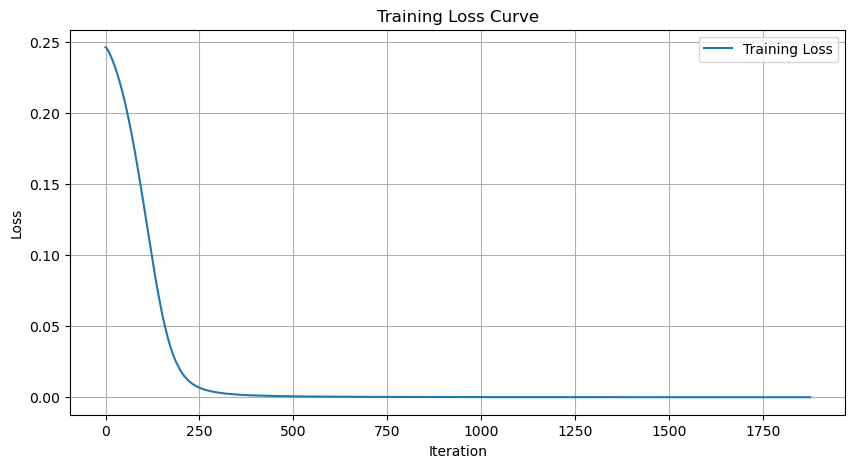

In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Lists to store loss values for plotting
train_losses = []

# Training Loop
for epoch in range(2):
    model.train()
    #epoch_loss = 0
    for inputs, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs = toTensor(inputs).view(-1,1,28,28)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape_as(inputs), inputs)
        loss.backward()
        optimizer.step()
        #epoch_loss += loss.item()

        #avg_epoch_loss = epoch_loss/len(train_loader)
        train_losses.append(loss.item()) # Store loss for plotting
        if (i + 1) % 100 == 0:
            print(f"loss: {loss.item()}")
    #print(f"loss: {loss.item()}")


# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
test_inputs = []
test_outputs = []
for inputs, _ in test_loader:
    outputs = model(inputs)
    test_inputs.append(inputs.detach().cpu().numpy())
    test_outputs.append(outputs.reshape_as(inputs).detach().cpu().numpy())

In [25]:
# DO NOT MODIFY
# Convert lists of tensors to numpy arrays
test_inputs = np.concatenate(test_inputs)
test_outputs = np.concatenate(test_outputs)

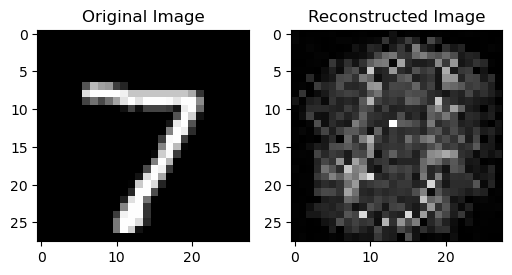

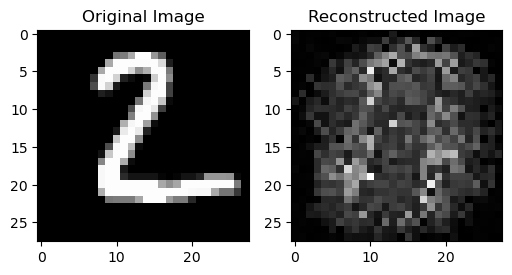

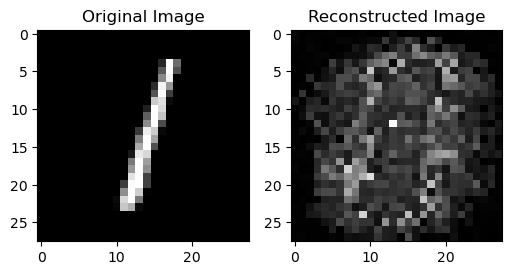

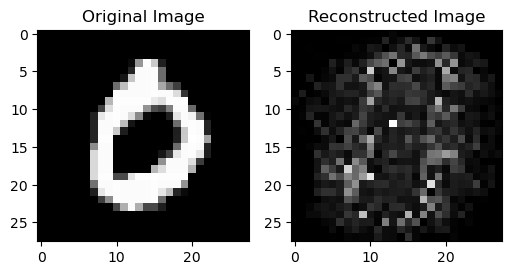

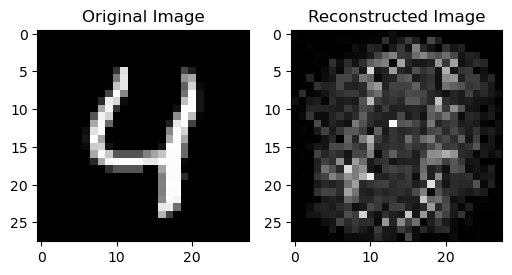

In [26]:
# DO NOT MODIFY
num_images = 5

for i in range(num_images):
    plt.figure(figsize=(6, 3))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_inputs[i, :, :], cmap="gray")
    plt.title("Original Image")

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(test_outputs[i, :, :], cmap="gray")
    plt.title("Reconstructed Image")

    plt.show()

## Summary
Changed the loss function to MSELoss which is more suited to the task at hand <br>
normalised the inputs so that each of the pixel values lies between 0 and 1 <br>
added optimizer.zero_grad() to make the gradients zero before backpropagation <br>
shaped the inputs appropriately to 28*28

# Section 2 - Improve the model

 *This section is more open-ended and less like the previous section.*

 **Expected time on this section: 30 minutes**<br>
**Maximum time on this section: 45 minutes**<br>

 In this section, you have to improve the model's performance by making changes to the training code to reduce the validation loss further. You are free to write your own autoencoder implementation in the AdvancedAutoencoder class, or use the same implementation from above.
Don't constraint yourself in this section! There are many ways to improve performance and you should feel free to try creative solutions. If the validation loss and corresponding visualization looks good to you, you can move to section 3 (and come back later to optimize the loss further if you want). If you are not able to achieve sufficiently low loss, then use our provided weights for section 3, otherwise use your own model. We provided a helper function for you to check if your validation loss is lower than the loss with our provided model's weights.

 Note:
 - We have written code to check the forward pass of your model doesn't exceed 0.05 seconds on a single batch. Make sure this condition is always satisfied.
 - You also need to implement your own `random_split` function.
 - One obvious thing one might do is to make the latent space dimension equal to the input dimension to achieve perfect zero loss. But this is not an autoencoder as it is not compressing the information. So latent space dimension should be fixed (=32) and should be not be "tuned".

 Also, feel free to reuse the code from previous section to get started.

In [27]:
class AdvancedAutoencoder(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    super(AdvancedAutoencoder, self).__init__()
    # TODO: Write your implementation here
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 64)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64, 32 * 7 * 7),
        nn.ReLU(),
        nn.Unflatten(1, (32, 7, 7)),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )
  def forward(self, x):
    # TODO: Write your implementation here
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [39]:
def toTensor(x):
    x = torch.from_numpy(np.array(x)).float() / 255.0
    return x.unsqueeze(0)

In [40]:
train_dataset = torch.load('data/mnist_dataset_train.pt')
train_dataset.transform = toTensor

test_dataset = torch.load('data/mnist_dataset_test.pt')
test_dataset.transform = toTensor

/tmp/ipykernel_6388/3757253876.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('data/mnist_dataset_train.pt')
/tmp/ipykernel_6388/3757253876.p

In [41]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [42]:
print(f"Input shape: {inputs.shape}")

Input shape: torch.Size([64, 28, 1, 28])


In [43]:
# DO NOT MODIFY
model = AdvancedAutoencoder()
max_allowed_time = 0.05  # seconds

# Measure time for the forward pass
i, (inputs, _) = next(enumerate(train_loader))
start_time = time.time()
output = model(inputs)
end_time = time.time()

# Measure once again, time for the forward pass
i, (inputs, _) = next(enumerate(train_loader))
start_time = time.time()
output = model(inputs)
end_time = time.time()

elapsed_time = end_time - start_time

# Assert the time constraint
assert elapsed_time <= max_allowed_time, f"Forward pass exceeded time limit! Took {elapsed_time:.8f} seconds"
print(f"Forward pass took {elapsed_time:.8f} seconds")

Forward pass took 0.00228786 seconds


In [46]:
def random_split(dataset, lengths):
    '''
    TODO: Implement this function from scratch using torch/numpy operations.
    Splits randomly a given dataset into two datasets,
    consisting of the specified lengths.
    '''
    total_size = len(dataset)
    
    # Calculate the indices for the split
    indices = torch.randperm(total_size).tolist()  # Generate a random permutation of indices
    
    # Split indices into the two parts
    split1_indices = indices[:lengths[0]]
    split2_indices = indices[lengths[0]:]
    
    # Create subsets of the dataset using the indices
    dataset1 = torch.utils.data.Subset(dataset, split1_indices)
    dataset2 = torch.utils.data.Subset(dataset, split2_indices)
    
    return dataset1, dataset2

In [47]:
# Calculate split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [48]:
# TODO: train your model and calculate validation loss (val_loss)

epochs = 10
learning_rate = 0.001
max_allowed_time = 0.05

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for i, (inputs, _) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, _ in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/10]
Training Loss: 0.0288, Validation Loss: 0.0081
Epoch [2/10]
Training Loss: 0.0063, Validation Loss: 0.0052
Epoch [3/10]
Training Loss: 0.0045, Validation Loss: 0.0041
Epoch [4/10]
Training Loss: 0.0037, Validation Loss: 0.0036
Epoch [5/10]
Training Loss: 0.0033, Validation Loss: 0.0032
Epoch [6/10]
Training Loss: 0.0031, Validation Loss: 0.0030
Epoch [7/10]
Training Loss: 0.0029, Validation Loss: 0.0028
Epoch [8/10]
Training Loss: 0.0027, Validation Loss: 0.0027
Epoch [9/10]
Training Loss: 0.0026, Validation Loss: 0.0026
Epoch [10/10]
Training Loss: 0.0025, Validation Loss: 0.0026


In [49]:
# DO NOT MODIFY
def check_loss_lower_than_reference_loss(your_val_loss)  -> bool:
  reference_loss = 0.0927
  assert your_val_loss < reference_loss, "Your validation loss is higher than our pretrained model's loss"

In [50]:
# TODO: verify your loss is lower than our reference loss
check_loss_lower_than_reference_loss(val_loss)

## Summary
implemented a convolutional autoencoder for better feature extraction and spatial understanding <br>
implemented a split function to divide the train ser into training and validation sets <br>
<br>
*what did not work*<br>
while validating that the forward pass does not exceed the time limit, i had issues with the input sizes, which I had to hammer down in re-implementing toTensor() function.

# Section 3 - Generate images from the autoencoder

In the final section, you will use your trained model from the previous section (or our pre-trained model, if you weren't able to complete the previous section) to sample images of hand-written digits given a digit in [0-9]. Specifically, you will implement the function `generate_image_from_digit(x: int, n_samples: int) -> NDArray[np.float32]` that returns an image. This function should sample images by sampling appropriate points in the $D_{latent}$-sized latent space and using the decoder to generate a new image for the digit. Every call to the function with the same digit should produce a different image.

**Expected time on this section: 30 minutes**<br>
**Maximum time on this section: 45 minutes**

In [ ]:
# You should use the below pretrained model, if you weren't able to complete the previous section well.
# model = load_pretrained_model()

In [64]:
def toTensor(x):
    x = torch.from_numpy(np.array(x)).float() / 255.0
    return x.unsqueeze(0)

train_dataset = torch.load('data/mnist_dataset_train.pt')
train_dataset.transform = toTensor

test_dataset = torch.load('data/mnist_dataset_test.pt')
test_dataset.transform = toTensor

/tmp/ipykernel_6388/2022305967.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('data/mnist_dataset_train.pt')
/tmp/ipykernel_6388/2022305967.p

In [65]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [68]:
def generate_image_from_digit(digit: int, n_samples: int) -> NDArray[np.float32]:
    """
    Returns an RGB MNIST image (with values between [0, 255]) as a 3D NumPy array of dtype float32.
    """
    assert digit <= 9  and digit >= 0, "Digit must be between 0 and 9"
    # TODO: Write your implementation here
    samples = []

    for i, (image, label) in enumerate(train_loader):
        matching_indices = (label == digit).nonzero(as_tuple=True)[0]
        
        for idx in matching_indices:
            samples.append(image[idx])

        if len(samples) >= n_samples:
            break

    if len(samples) == 0:
        raise ValueError(f"No samples found for digit {digit}")

    generated_images = []

    for _ in range(n_samples):
        sample_image = random.choice(samples)
        sample_image = sample_image.unsqueeze(0)

        model.eval()
        with torch.no_grad():
            reconstructed_image = model(sample_image)

        reconstructed_image = reconstructed_image.squeeze().cpu().numpy()

        rgb_image = np.stack([reconstructed_image] * 3, axis=-1)

        rgb_image = np.clip(rgb_image * 255.0, 0, 255).astype(np.float32)

        generated_images.append(rgb_image)

    return np.array(generated_images)
    #return np.zeros((28, 28, 3), dtype=np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.0409986e-16..254.19725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.709887e-12..254.51788].


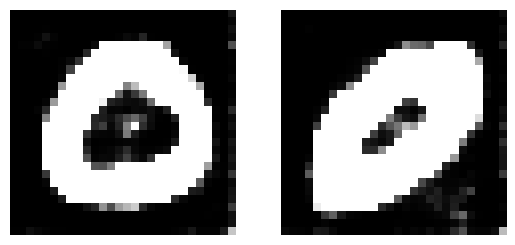

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.1581556e-09..241.16745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.9936647e-10..253.95854].


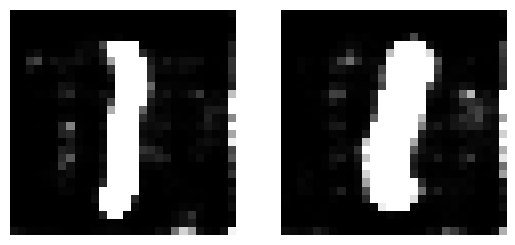

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.6232504e-12..253.52383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.8620545e-09..253.99864].


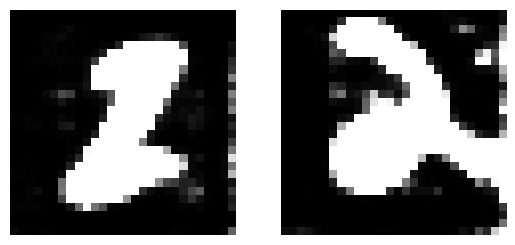

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.6325112e-16..251.6438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.6325112e-16..251.6438].


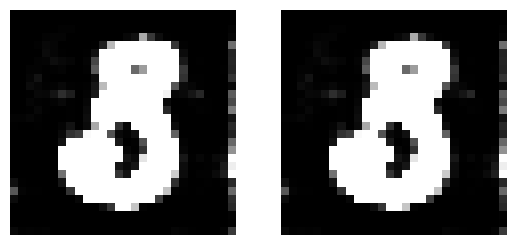

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.5521328e-10..247.34306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.294865e-12..252.86844].


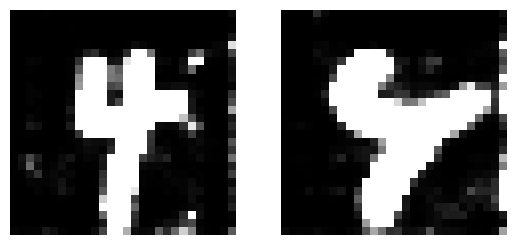

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.6543544e-10..250.99638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.662872e-20..253.69604].


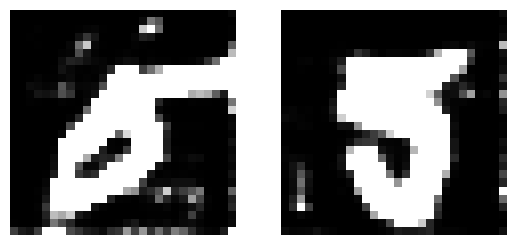

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.967116e-09..251.09676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.967116e-09..251.09676].


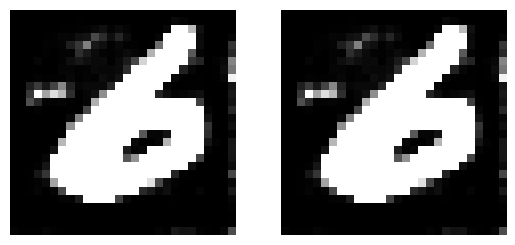

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.642628e-12..251.83653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.46546e-15..254.09648].


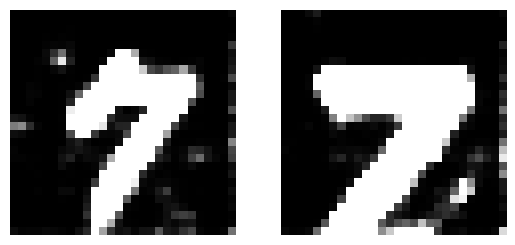

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.7256144e-14..250.62997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.379289e-12..251.11499].


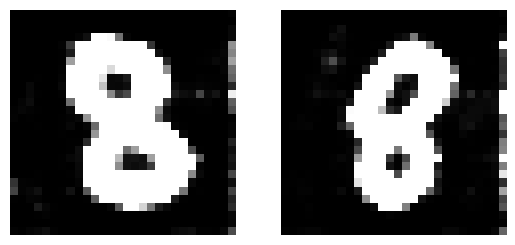

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.9459157e-10..254.03786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.563934e-10..247.3322].


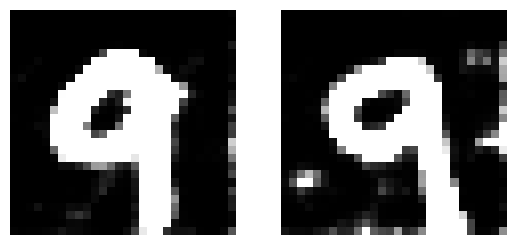

In [69]:
'''def visualise_images(digit, n_samples):
  generated_images = generate_image_from_digit(digit, n_samples)
  for i in range(n_samples):
      plt.subplot(1, n_samples, i + 1)
      plt.imshow(generated_images[i], cmap='gray')
      plt.axis('off')

  plt.show()

for digit in range(10):
  visualise_images(digit, 2)'''

def visualise_images(digit, n_samples):
    generated_images = generate_image_from_digit(digit, n_samples)
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')

    plt.show()

for digit in range(10):
    visualise_images(digit, 2)

In [70]:
def check_generator_produces_different_images(digit):
    generated_images = [generate_image_from_digit(digit, 1) for _ in range(2)]
    return not torch.allclose(torch.from_numpy(generated_images[0]), torch.from_numpy(generated_images[1]))

In [71]:
for digit in range(10):
  assert check_generator_produces_different_images(digit), "Generator must be able to produce different images for the same digit"

## Summary
implemented an image generator function that selects the specified number of samples from the train_loader <br>
the function randomly selects an image out of the sample to pass through the autoencoder <br>
the greyscale images are converted to RGB and scaled in the range [0,255] for visualisation <br>
<br>
*issues encountered*<br>
the improper datatypes while extracting the label out of the scalar while it was actually a tensor.